# Earthquake vs Noise Classification Using Time-Series Waveforms

This project explores whether simple machine learning + deep learning models can distinguish earthquake events from background noise using raw 3-channel waveform data. Each trace contains 6000 samples across 3 channels, digitized at 14 bits.

The goals of this project are to:

* Build a clean preprocessing pipeline for filtering and standardizing the data

* Train a baseline model (Isolation Forest) to see if unsupervised anomaly detection can separate noise from earthquakes

* Train a Convolutional Autoencoder / CNN model to learn time-domain features directly from waveforms

* Compare both approaches and measure how well each detects earthquake events

In [37]:
# Import necessary libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from scipy.signal import butter, filtfilt, detrend
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set pandas display options
pd.set_option('display.max_columns', None)

## Loading Metadata for Noise and Earthquake Events

Here we load the CSV metadata for noise and earthquake traces. Each entry contains a trace_name that we use to look up the full waveform inside the HDF5 files.

* noise_df contains non-event noise traces

* The HDF5 files hold the raw waveforms and their attributes (sampling frequency, number of channels, etc.)

We also grab a single example trace from each dataset so we can inspect its attributes and confirm the structure.

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,s_arrival_sample,s_status,s_weight,source_id,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_error_sec,source_gap_deg,source_horizontal_uncertainty_km,source_depth_km,source_depth_uncertainty_km,source_magnitude,source_magnitude_type,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 00:17:30,noise,113A.AE_20180115001730_NO
1,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 00:33:36,noise,113A.AE_20180115003336_NO
2,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 02:01:06,noise,113A.AE_20180115020106_NO
3,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 02:29:06,noise,113A.AE_20180115022906_NO
4,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 03:51:00,noise,113A.AE_20180115035100_NO


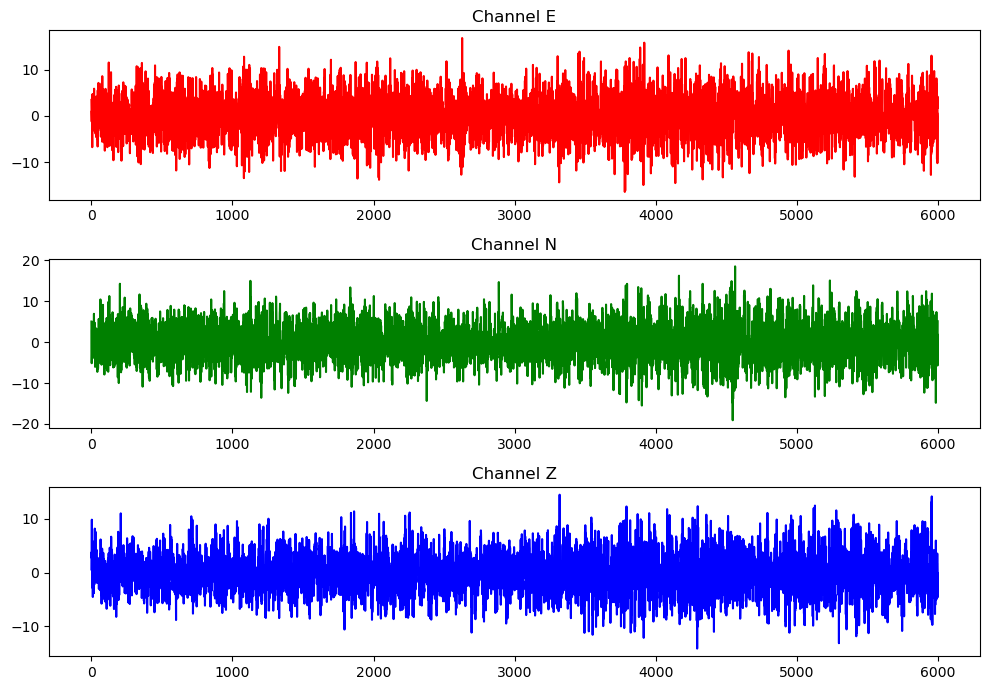

In [38]:
# Read in noise data
noise_df = pd.read_csv('Noise/chunk1.csv')

display(noise_df.head())

# Extract noise event list
noise_ev_list = noise_df['trace_name'].tolist()

# Read and plot first noise data for visualization
noise_h5 = h5py.File('Noise/chunk1.hdf5', 'r')

# Extract 3000 noise traces
noise_data = []
for event in noise_ev_list[:3000]:
    trace = noise_h5['data/' + event][:]
    noise_data.append(trace)

# Each trace has three channels
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

# Plot first noise trace channels
ax[0].plot(noise_data[0][:, 0], color='r')
ax[0].set_title('Channel E')

ax[1].plot(noise_data[0][:, 1], color='g')
ax[1].set_title('Channel N')

ax[2].plot(noise_data[0][:, 2], color='b')
ax[2].set_title('Channel Z')

fig.tight_layout();

Now we do the same for actual earthquake events:

/var/folders/gl/r80t9pmj4mqd53jx567r1z3w0000gn/T/ipykernel_72119/3292075595.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  earthquake_df = pd.read_csv('Earthquake/chunk2.csv')


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,s_arrival_sample,s_status,s_weight,source_id,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_error_sec,source_gap_deg,source_horizontal_uncertainty_km,source_depth_km,source_depth_uncertainty_km,source_magnitude,source_magnitude_type,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,17.080000,1894.0,manual,0.5,8556349,2006-07-23 15:58:50.88,0.47,33.7496,-117.4938,1.1119,107.466,4.6403,0.45,NaN,3.6,ml,NaN,NaN,0.92,102.09,159.3,[56.79999924 55.40000153 47.40000153],[[2896.]],2006-07-23 15:59:00.960000,earthquake_local,109C.TA_20060723155859_EV
1,TA,109C,BH,32.8889,-117.1051,150.0,600.0,manual,0.5,16.879999,1763.0,manual,0.5,8860238,2006-11-03 15:56:42.73,0.24,32.7077,-116.0446,0.8990,37.593,2.9542,9.20,NaN,4.3,mb,NaN,NaN,0.91,101.34,281.7,[65. 65.5 61.40000153],[[5508.]],2006-11-03 15:56:53.610000,earthquake_local,109C.TA_20061103155652_EV
2,TA,109C,BH,32.8889,-117.1051,150.0,500.0,manual,0.5,17.260000,1678.0,manual,0.5,8940123,2006-11-03 16:12:12.44,0.27,32.7253,-116.0348,0.8127,48.096,3.0397,12.66,NaN,3.6,ml,NaN,NaN,0.92,101.87,280.5,[37.20000076 42. 38.59999847],[[3114.]],2006-11-03 16:12:24.700000,earthquake_local,109C.TA_20061103161223_EV
3,TA,109C,BH,32.8889,-117.1051,150.0,900.0,manual,0.5,17.280001,2086.0,manual,0.5,9443190,2006-11-14 13:32:14.26,0.25,32.7063,-116.0241,0.9173,43.783,2.6112,11.50,NaN,3.8,ml,NaN,NaN,0.93,103.26,281.6,[54.09999847 54.90000153 45.5 ],[[3152.]],2006-11-14 13:32:22.540000,earthquake_local,109C.TA_20061114133221_EV
4,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,18.139999,1897.0,manual,0.5,9443449,2006-11-27 10:46:29.92,0.67,31.9679,-117.1944,1.0362,182.145,5.6607,7.26,NaN,3.6,ml,NaN,NaN,0.92,102.48,4.7,[58.20000076 56.20000076 53.79999924],[[3134.]],2006-11-27 10:46:41.060000,earthquake_local,109C.TA_20061127104640_EV


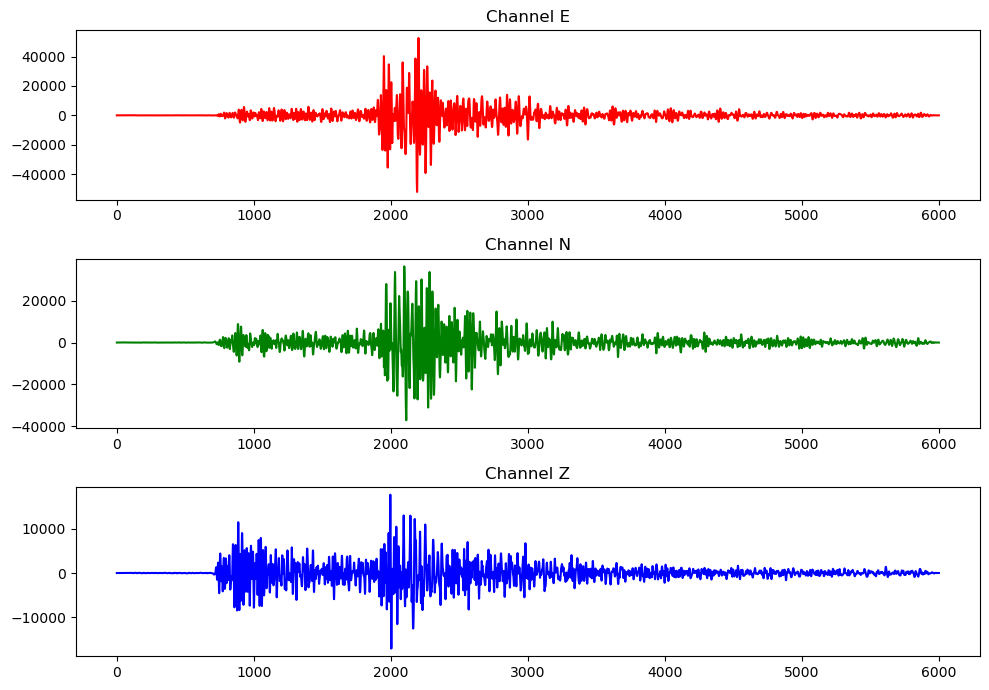

In [39]:
# Read in earthquake data
earthquake_df = pd.read_csv('Earthquake/chunk2.csv')

display(earthquake_df.head())

# Extract earthquake event list
earthquake_ev_list = earthquake_df['trace_name'].tolist()

# Extract 3000 earthquake traces
earthquake_data = []
earthquake_h5 = h5py.File('Earthquake/chunk2.hdf5', 'r')
for event in earthquake_ev_list[:3000]:
    trace = earthquake_h5['data/' + event][:]
    earthquake_data.append(trace)

earthquake_data = np.array(earthquake_data)

# Each trace has three channels
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

# Plot first earthquake trace channels
ax[0].plot(earthquake_data[0][:, 0], color='r')
ax[0].set_title('Channel E')

ax[1].plot(earthquake_data[0][:, 1], color='g')
ax[1].set_title('Channel N')

ax[2].plot(earthquake_data[0][:, 2], color='b')
ax[2].set_title('Channel Z')

fig.tight_layout();

In [4]:
# Read out the different attributes for noise and earthquake data
noise_attributes = noise_h5['data/' + noise_ev_list[0]].attrs
earthquake_attributes = earthquake_h5['data/' + earthquake_ev_list[0]].attrs

# Check if they have same attributes
if set(noise_attributes.keys()) == set(earthquake_attributes.keys()):
    print("\nBoth datasets have the same attributes:")
    for key in noise_attributes.keys():
        print(f"{key}")
else:
    print("\nDatasets have different attributes:")
    print("Noise Data Attributes:")
    for key, value in noise_attributes.items():
        print(f"{key}: {value}")

    print("\nEarthquake Data Attributes:")
    for key, value in earthquake_attributes.items():
        print(f"{key}: {value}")


Both datasets have the same attributes:
back_azimuth_deg
coda_end_sample
network_code
p_arrival_sample
p_status
p_travel_sec
p_weight
receiver_code
receiver_elevation_m
receiver_latitude
receiver_longitude
receiver_type
s_arrival_sample
s_status
s_weight
snr_db
source_depth_km
source_depth_uncertainty_km
source_distance_deg
source_distance_km
source_error_sec
source_gap_deg
source_horizontal_uncertainty_km
source_id
source_latitude
source_longitude
source_magnitude
source_magnitude_author
source_magnitude_type
source_mechanism_strike_dip_rake
source_origin_time
source_origin_uncertainty_sec
trace_category
trace_name
trace_start_time


## Preprocessing Function

To prepare the raw waveforms for machine learning, we build a preprocessing pipeline that does the following:

* Extracts the waveform array from the HDF5 file

* Applies a 1 to 20 Hz bandpass filter (This range captures most earthquake energy and removes long-period drift + high-frequency noise)

* Normalizes each channel

* Standardizes the result so it can be fed to ML models

This function outputs a clean version of each trace that has consistent scaling and reduced noise.

In [ ]:
# Make processing function for training + testing data
def preprocess_trace(trace):

    # Detrend the trace
    trace = detrend(trace)
    
    # Apply a bandpass filter between 1 Hz and 20 Hz
    fs = 100  # Sampling frequency
    lowcut  = 1.0
    highcut = 20.0
    
    nyquist = 0.5 * fs
    low  = lowcut / nyquist
    high = highcut / nyquist
    
    b, a = butter(4, [low, high], btype='band')
    filtered_trace = filtfilt(b, a, trace)
    
    return filtered_trace

## Isolation Forest training

### Below we train an Isolation Forest using flattened arrays of each data sample (6000, 3) -> (18000)
* We train on the noise only such that anything that looks different from noise gets marked as anomaly.

In [6]:
# Prepare labels and data for training
# Noise = 0, Earthquake = 1
X = np.concatenate([noise_data, earthquake_data], axis=0)
y = np.concatenate([np.zeros(len(noise_data)), np.ones(len(earthquake_data))])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Train isolation forest model
X_train_noise = X_train_scaled[y_train == 0]  # Use only noise data for training

iso_forest = IsolationForest(
    n_estimators=300,
    contamination='auto', 
    random_state=42,
    bootstrap=False)

iso_forest.fit(X_train_noise)
y_pred = iso_forest.predict(X_test_scaled)
y_pred = np.where(y_pred == 1, 0, 1)  # Map normal to 0 and anomaly to 1

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[560  40]
 [ 28 572]]
              precision    recall  f1-score   support

         0.0     0.9524    0.9333    0.9428       600
         1.0     0.9346    0.9533    0.9439       600

    accuracy                         0.9433      1200
   macro avg     0.9435    0.9433    0.9433      1200
weighted avg     0.9435    0.9433    0.9433      1200



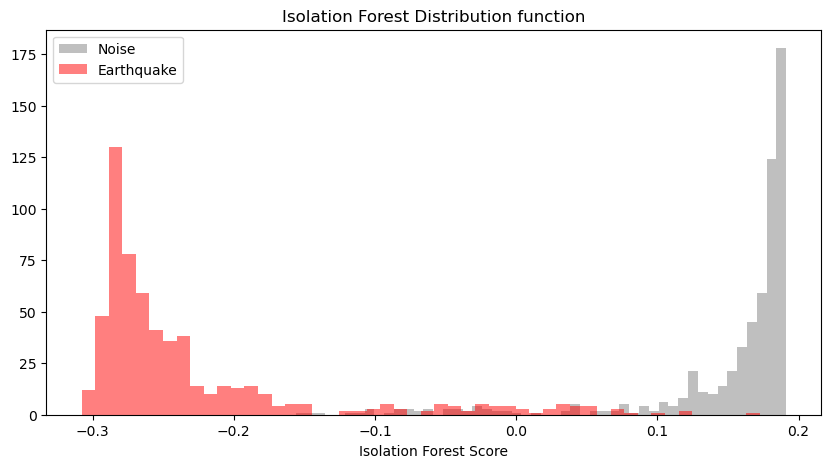

In [7]:
# Visualization of decisions
scores = iso_forest.decision_function(X_test_scaled)

plt.figure(figsize=(10, 5))
plt.hist(scores[y_test == 0], bins=50, color='gray', alpha=0.5, label='Noise')
plt.hist(scores[y_test == 1], bins=50, color='red', alpha=0.5, label='Earthquake')
plt.xlabel('Isolation Forest Score')
plt.title('Isolation Forest Distribution function')
plt.legend()
plt.show()

### Now we train a different Isolation Forest using extracted time features from the data.

* We sum all the different features from each channel and use this baseline as noise. 
* Any sums that deviate from this baseline will be considered anomalies.

In [40]:
# Feature extraction function for time-domain

def time_features(signal):
    # x shape: (6000,3)
    feats = []
    for ch in range(3):
        sig = signal[:,ch]
        feats += [
            np.mean(sig),
            np.std(sig),
            np.sqrt(np.mean(sig**2)),  # RMS
            np.max(sig)-np.min(sig),   # Peak-to-peak
            np.mean(np.abs(sig)),      # Mean amplitude
            np.mean((sig - np.mean(sig))**4) / (np.var(sig)**2 + 1e-8)  # Kurtosis
        ]
    return np.array(feats)

In [15]:
# Use time-domain features with Isolation Forest
X_time_features = np.array([time_features(trace) for trace in X])
y_time = y.copy()

# split into train and test sets
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    X_time_features, y_time, test_size=0.2, random_state=42, stratify=y_time)

# Scale the time-domain features
scaler_tf = StandardScaler()
X_train_tf_scaled = scaler_tf.fit_transform(X_train_tf)
X_test_tf_scaled = scaler_tf.transform(X_test_tf)

# Train isolation forest model on time-domain features
X_train_tf_noise = X_train_tf_scaled[y_train_tf == 0]  # Use only noise data for training

iso_forest_tf = IsolationForest(
    n_estimators=300,
    contamination='auto', 
    random_state=42,
    bootstrap=False)

iso_forest_tf.fit(X_train_tf_noise)
y_pred_tf = iso_forest_tf.predict(X_test_tf_scaled)
y_pred_tf = np.where(y_pred_tf == 1, 0, 1)  # Map normal to 0 and anomaly to 1

print(confusion_matrix(y_test_tf, y_pred_tf))
print(classification_report(y_test_tf, y_pred_tf, digits=4))

[[540  60]
 [  2 598]]
              precision    recall  f1-score   support

         0.0     0.9963    0.9000    0.9457       600
         1.0     0.9088    0.9967    0.9507       600

    accuracy                         0.9483      1200
   macro avg     0.9526    0.9483    0.9482      1200
weighted avg     0.9526    0.9483    0.9482      1200



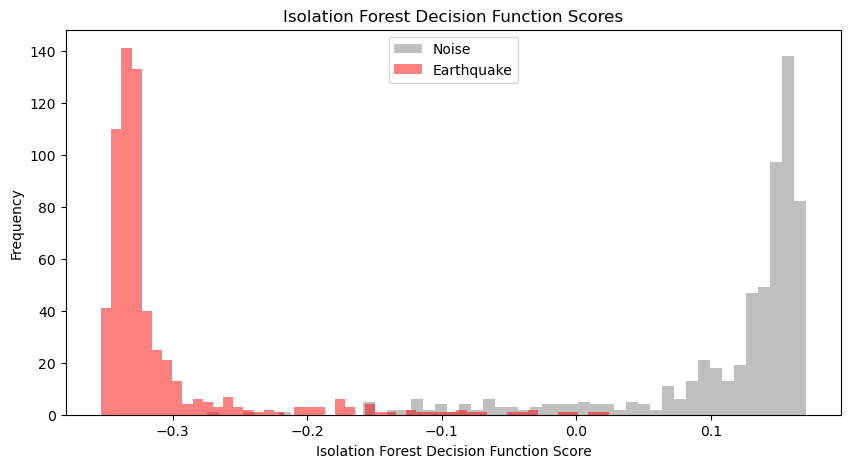

In [ ]:
# Visualization of decisions
scores_tf = iso_forest_tf.decision_function(X_test_tf_scaled)

plt.figure(figsize=(10, 5))
plt.hist(scores_tf[y_test_tf == 0], bins=50, color='gray', alpha=0.5, label='Noise')
plt.hist(scores_tf[y_test_tf == 1], bins=50, color='red', alpha=0.5, label='Earthquake')
plt.xlabel('Isolation Forest Decision Function Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest Decision Function Scores')
plt.legend();

In [10]:
# Compare both models' performance based on classification reports and confusion matrices

print("Model with Flattened Traces:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

print()

print("Model with Time-Domain Features:")
print(confusion_matrix(y_test_tf, y_pred_tf))
print(classification_report(y_test_tf, y_pred_tf, digits=4))

Model with Flattened Traces:
[[560  40]
 [ 28 572]]
              precision    recall  f1-score   support

         0.0     0.9524    0.9333    0.9428       600
         1.0     0.9346    0.9533    0.9439       600

    accuracy                         0.9433      1200
   macro avg     0.9435    0.9433    0.9433      1200
weighted avg     0.9435    0.9433    0.9433      1200


Model with Time-Domain Features:
[[540  60]
 [  2 598]]
              precision    recall  f1-score   support

         0.0     0.9963    0.9000    0.9457       600
         1.0     0.9088    0.9967    0.9507       600

    accuracy                         0.9483      1200
   macro avg     0.9526    0.9483    0.9482      1200
weighted avg     0.9526    0.9483    0.9482      1200



#### Using time-domain features instead of flattening the 3 channels into a single trace seems to improve the model's ability to distinguish between noise and earthquake events. However, it produced higher amounts of false positives, as seen in the confusion matrix. Despite the first model having a higher precision for detecting anomalies, the second model definetly has the best balance as it has significantly lower rates of false negatives and has a higher f1-score.

## Neural Network Training

#### Now let's train a Convolutional Autoencoder to see if we can achieve a better detection rate and a higher accuracy score overall.

In [11]:
# Train with CNN model
from network import CNN
import keras 

# Use 3 channel input with 2400 samples
print(X_train.shape)
input_shape = (6000, 3)  # (6000, 3)

# Reshape scaled training and testing data for CNN
X_train_cnn = X_train_scaled.reshape(X_train.shape[0], input_shape[0], input_shape[1])
X_test_cnn = X_test_scaled.reshape(X_test.shape[0], input_shape[0], input_shape[1])

cnn_model = CNN(input_shape=input_shape)
cnn_model.compile(optimizer='adam', loss='mse')

# Add callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

# Train only on noise data
cnn_model.fit(
    X_train_cnn[y_train == 0], 
    X_train_cnn[y_train == 0], 
    epochs=20, 
    batch_size=32, 
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stopping]);

(4800, 6000, 3)
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 526ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 534ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 646ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 613ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 624ms/step - loss: 0.0013 - val_loss: 0.0014


In [20]:
# Evaluate CNN model
X_test_pred = cnn_model.predict(X_test)
mae = np.mean(np.abs(X_test_cnn - X_test_pred), axis=(1,2))

# 96th percentile chosen by varying threshold and finding best balance between precision and recall
threshold = np.percentile(mae[y_test == 0], 96)  
y_pred_cnn = (mae > threshold).astype(int)

print(confusion_matrix(y_test, y_pred_cnn))
print(classification_report(y_test, y_pred_cnn, digits=4))

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step
[[576  24]
 [ 22 578]]
              precision    recall  f1-score   support

         0.0     0.9632    0.9600    0.9616       600
         1.0     0.9601    0.9633    0.9617       600

    accuracy                         0.9617      1200
   macro avg     0.9617    0.9617    0.9617      1200
weighted avg     0.9617    0.9617    0.9617      1200



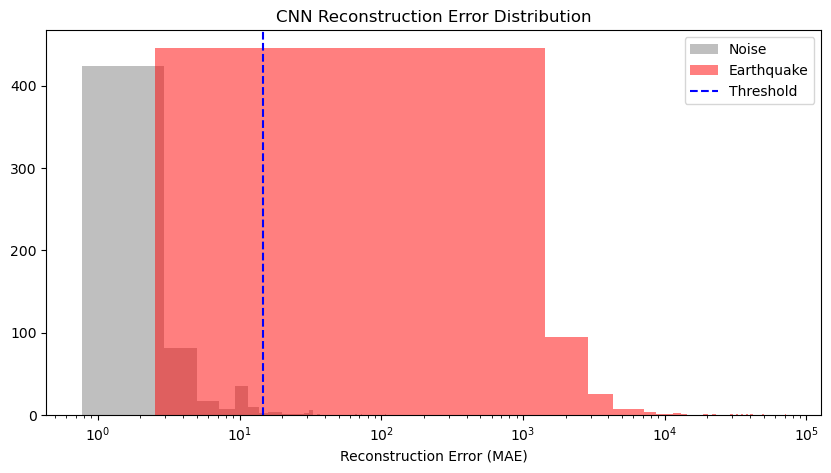

In [21]:
# Visualization of CNN reconstruction errors

plt.figure(figsize=(10, 5))
plt.hist(mae[y_test == 0], bins=50, color='gray', alpha=0.5, label='Noise')
plt.hist(mae[y_test == 1], bins=50, color='red', alpha=0.5, label='Earthquake')
plt.axvline(threshold, color='blue', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error (MAE)')
plt.xscale('log')
plt.title('CNN Reconstruction Error Distribution')
plt.legend();

There is clearly some overlap between the noise and earthquake events for MAE between (25, 150). The 96th percentile threshold, however, cut off the majority of possible false positives.

## Final Results

Here we evaluate the results of all three models to find the best detector. Below are the confusion matrices for the three:

In [13]:
print("Model with flattened traces:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

print("Model with time-domain features:")
print(confusion_matrix(y_test_tf, y_pred_tf))
print(classification_report(y_test_tf, y_pred_tf, digits=4))

print("Model with CNN:")
print(confusion_matrix(y_test, y_pred_cnn))
print(classification_report(y_test, y_pred_cnn, digits=4))

Model with flattened traces:
[[560  40]
 [ 28 572]]
              precision    recall  f1-score   support

         0.0     0.9524    0.9333    0.9428       600
         1.0     0.9346    0.9533    0.9439       600

    accuracy                         0.9433      1200
   macro avg     0.9435    0.9433    0.9433      1200
weighted avg     0.9435    0.9433    0.9433      1200

Model with time-domain features:
[[540  60]
 [  2 598]]
              precision    recall  f1-score   support

         0.0     0.9963    0.9000    0.9457       600
         1.0     0.9088    0.9967    0.9507       600

    accuracy                         0.9483      1200
   macro avg     0.9526    0.9483    0.9482      1200
weighted avg     0.9526    0.9483    0.9482      1200

Model with CNN:
[[576  24]
 [ 22 578]]
              precision    recall  f1-score   support

         0.0     0.9632    0.9600    0.9616       600
         1.0     0.9601    0.9633    0.9617       600

    accuracy                       

### Key Takeaways:
* CNN-based methods outperform the statistical baseline, achieving 96.17% accuracy compared to its counterparts (94.33% and 94.83%)

* Using the full 3-channel time structure leads to better discrimination

* Filtering + scaling are crucial for preparing seismic waveforms

* Future work could include spectrogram features, RNNs, or transformer-based models